# Tree Crown Detection Evaluation

This notebook compares tree crown detections from Detectree2 (in `.gpkg`) against ground truth polygons (in COCO `.json` format). It aligns coordinate systems using a georeferenced orthomosaic (`.tif`) and computes detection metrics and visualizations.

In [1]:
# 📦 Imports
import json
import fiona
import rasterio
import matplotlib.pyplot as plt
from shapely.geometry import shape, Polygon
from shapely.affinity import affine_transform

## Step 1: Load the input files

In [2]:
# === File Paths ===
json_path = "large_files/instances_default.json"
gpkg_path = "large_files/tiles_sit_om2/crowns_map.gpkg"
tif_path = "large_files/sit_om2.tif"

In [3]:
# === Load COCO JSON (Pixel Coordinates) ===
with open(json_path, "r") as f:
    coco_data = json.load(f)

gt_pixel_polygons = [
    Polygon(list(zip(ann["segmentation"][0][::2], ann["segmentation"][0][1::2])))
    for ann in coco_data["annotations"]
]

In [4]:
# === Load GPKG Polygons ===
gpkg_polygons = []
with fiona.open(gpkg_path, "r") as src:
    for feature in src:
        gpkg_polygons.append(shape(feature["geometry"]))

In [5]:
# === Load Orthomosaic (GeoTIFF) ===
with rasterio.open(tif_path) as src:
    transform = src.transform
    ortho_img = src.read([1, 2, 3])
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

## Step 2: Convert COCO annotations to UTM using orthomosaic transform

In [6]:
affine_params = [
    transform.a, transform.b,
    transform.d, transform.e,
    transform.xoff, transform.yoff
]

gt_polygons_utm = [affine_transform(poly, affine_params) for poly in gt_pixel_polygons]

## Step 3: Match predictions with ground truth (IoU ≥ 0.5)

In [7]:
def compute_iou(poly1, poly2):
    if not poly1.is_valid or not poly2.is_valid:
        return 0.0
    inter = poly1.intersection(poly2).area
    union = poly1.union(poly2).area
    return inter / union if union > 0 else 0.0

IOU_THRESHOLD = 0.5
matches, used_gt, used_pred = [], set(), set()

for i, gt in enumerate(gt_polygons_utm):
    best_iou, best_j = 0, -1
    for j, pred in enumerate(gpkg_polygons):
        if j in used_pred:
            continue
        iou = compute_iou(gt, pred)
        if iou > best_iou:
            best_iou, best_j = iou, j
    if best_iou >= IOU_THRESHOLD:
        matches.append((i, best_j, best_iou))
        used_gt.add(i)
        used_pred.add(best_j)

tp_polys = [gpkg_polygons[j] for (_, j, _) in matches]
fn_polys = [gt_polygons_utm[i] for i in range(len(gt_polygons_utm)) if i not in used_gt]
fp_polys = [gpkg_polygons[j] for j in range(len(gpkg_polygons)) if j not in used_pred]

## Step 4: Visualizations

In [8]:
def plot_polygons(polys, title, color):
    fig, ax = plt.subplots(figsize=(10, 10))
    for poly in polys:
        x, y = poly.exterior.xy
        ax.fill(x, y, alpha=0.5, fc=color, ec='black')
    ax.set_aspect('equal')
    ax.set_title(title)
    plt.show()

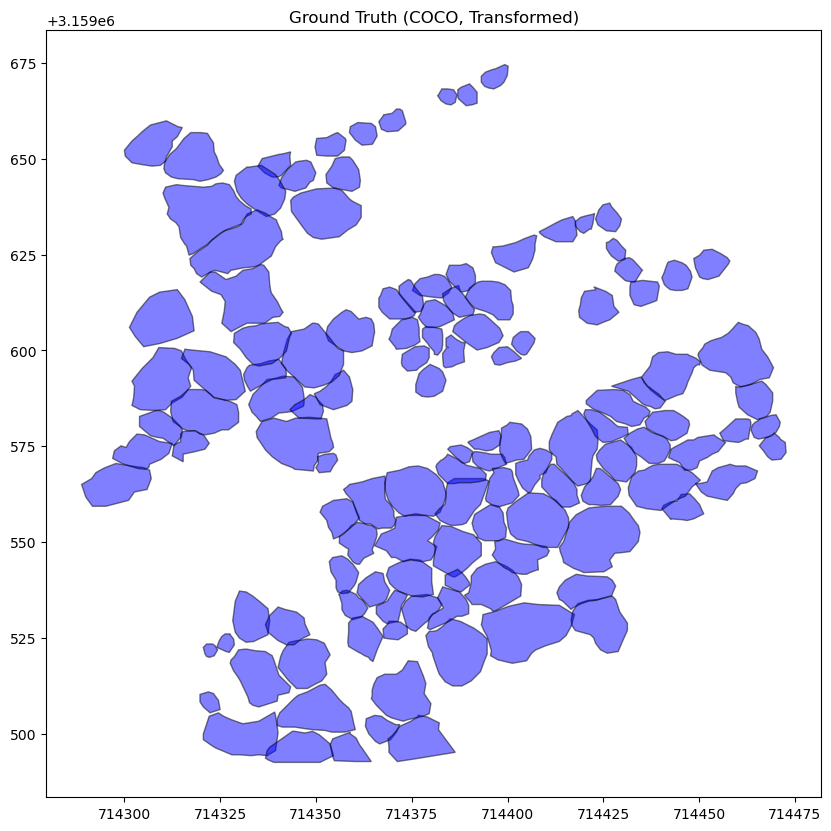

In [9]:
# 1. Ground Truth only
plot_polygons(gt_polygons_utm, "Ground Truth (COCO, Transformed)", "blue")

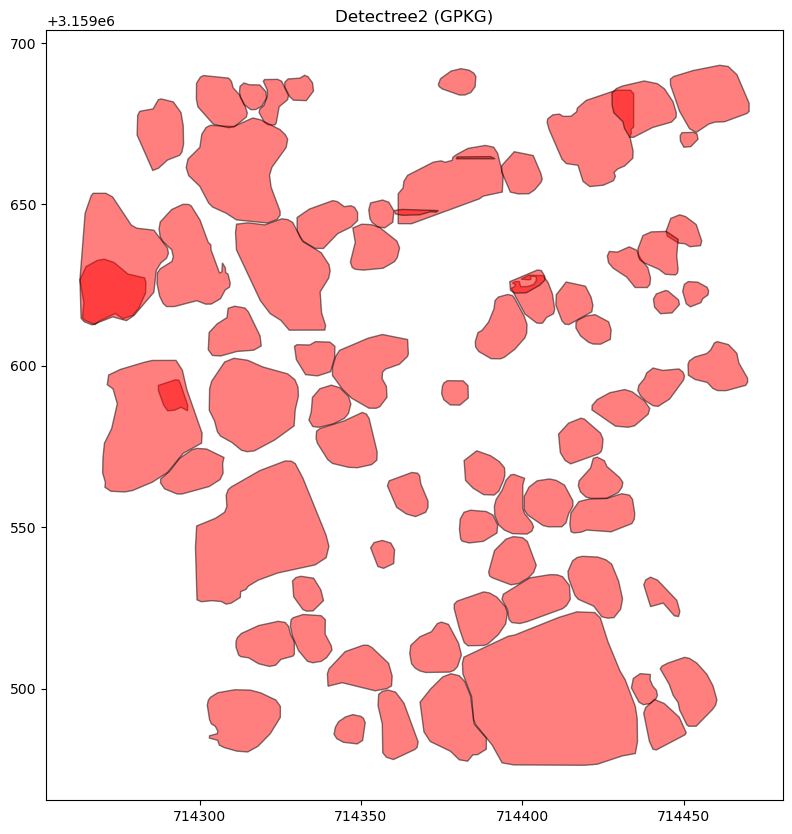

In [10]:
# 2. Detectree2 only
plot_polygons(gpkg_polygons, "Detectree2 (GPKG)", "red")

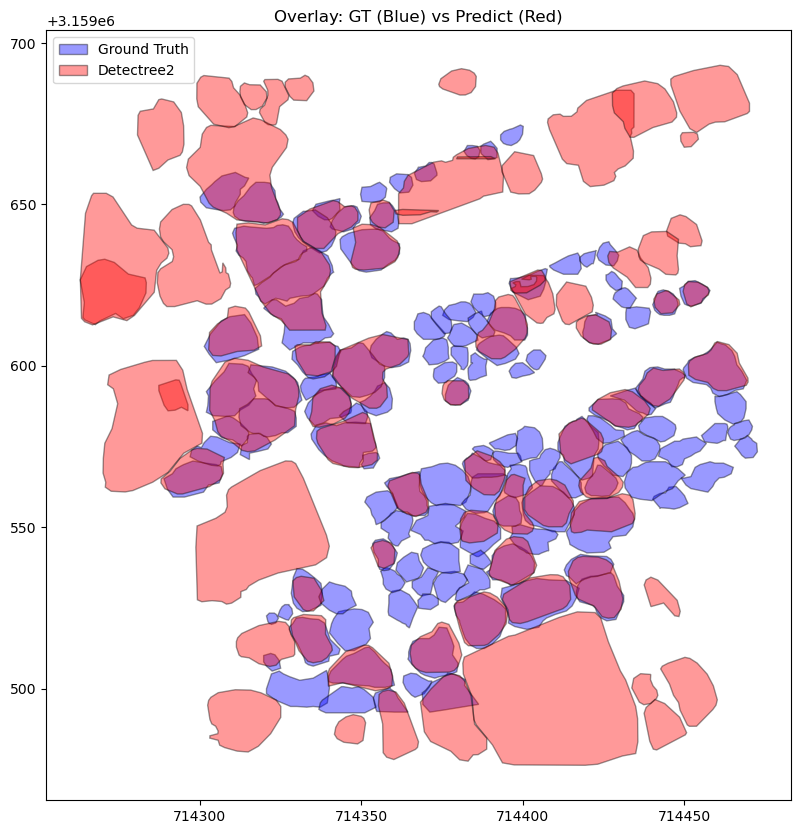

In [11]:
# 3. Overlay Both
fig, ax = plt.subplots(figsize=(10, 10))
for poly in gt_polygons_utm:
    x, y = poly.exterior.xy
    ax.fill(x, y, alpha=0.4, fc='blue', ec='black', label='Ground Truth')
for poly in gpkg_polygons:
    x, y = poly.exterior.xy
    ax.fill(x, y, alpha=0.4, fc='red', ec='black', label='Detectree2')
ax.set_aspect('equal')
ax.set_title("Overlay: GT (Blue) vs Predict (Red)")
handles, labels = ax.get_legend_handles_labels()
ax.legend(dict(zip(labels, handles)).values(), dict(zip(labels, handles)).keys())
plt.show()

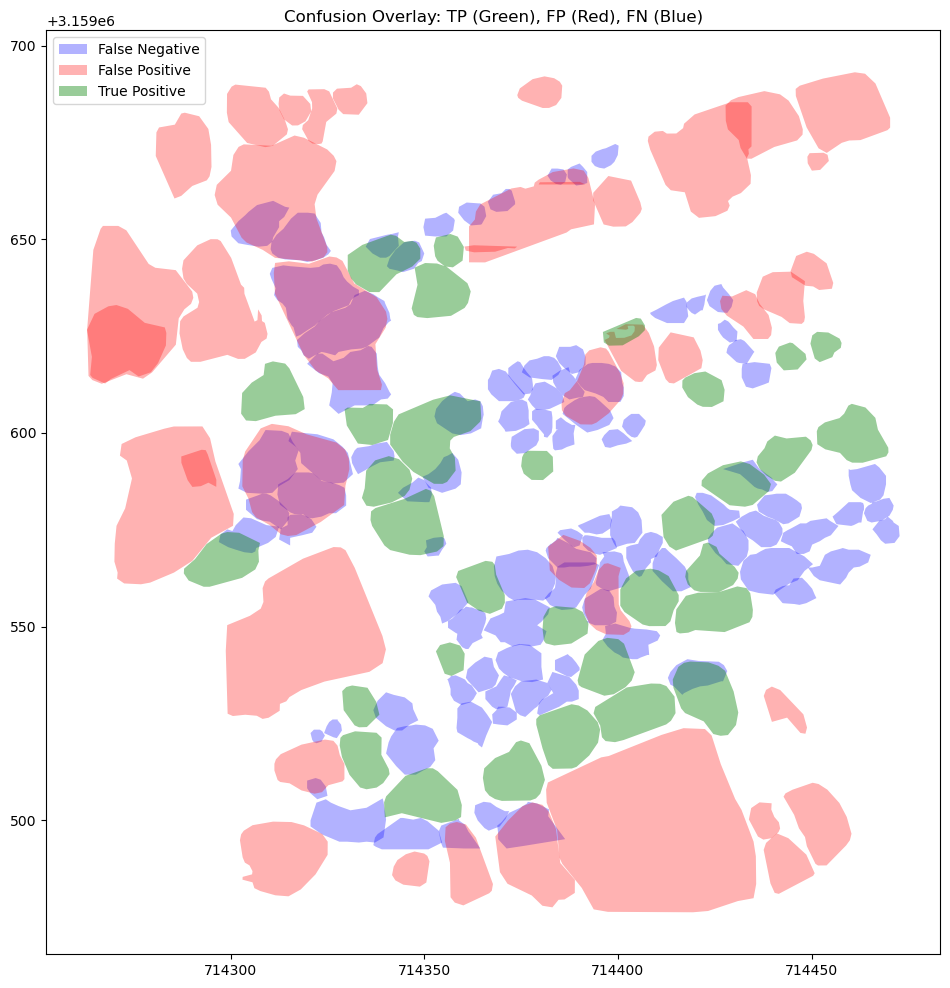

In [12]:
# 4. Confusion Overlay
fig, ax = plt.subplots(figsize=(12, 12))
for poly in fn_polys:
    x, y = poly.exterior.xy
    ax.fill(x, y, alpha=0.3, fc='blue', label='False Negative')
for poly in fp_polys:
    x, y = poly.exterior.xy
    ax.fill(x, y, alpha=0.3, fc='red', label='False Positive')
for poly in tp_polys:
    x, y = poly.exterior.xy
    ax.fill(x, y, alpha=0.4, fc='green', label='True Positive')
ax.set_title("Confusion Overlay: TP (Green), FP (Red), FN (Blue)")
ax.set_aspect('equal')
handles, labels = ax.get_legend_handles_labels()
ax.legend(dict(zip(labels, handles)).values(), dict(zip(labels, handles)).keys())
plt.show()

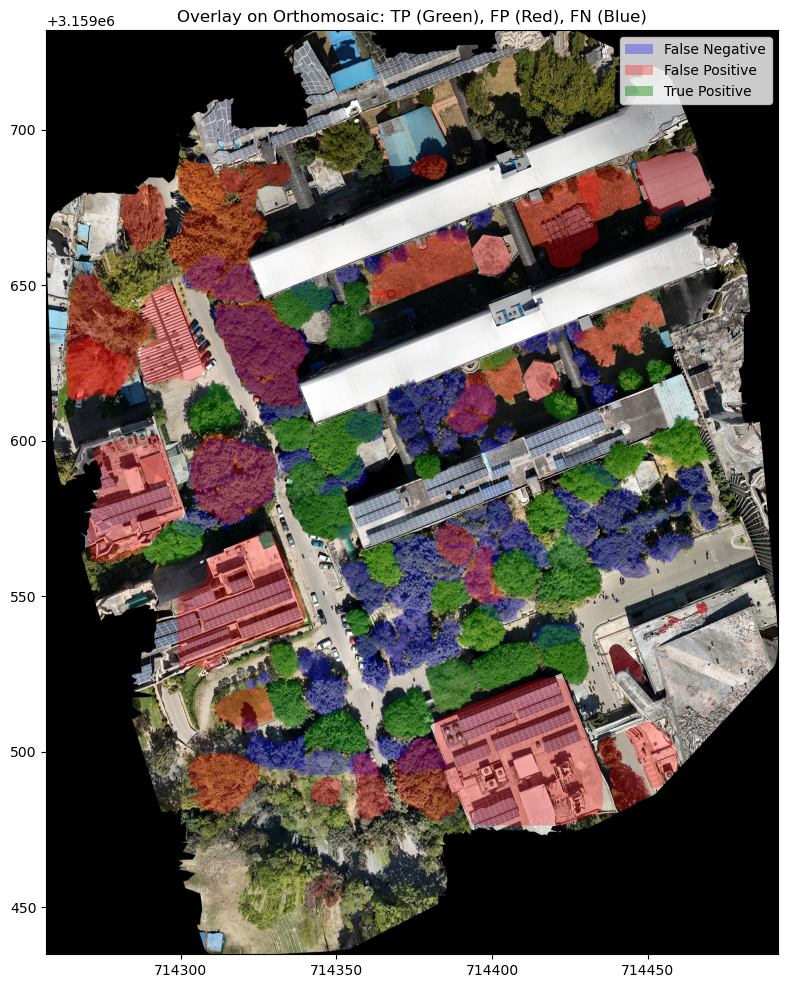

In [13]:
# 5. Overlay on Orthomosaic
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(ortho_img.transpose(1, 2, 0), extent=extent)
for poly in fn_polys:
    x, y = poly.exterior.xy
    ax.fill(x, y, alpha=0.3, fc='blue', label='False Negative')
for poly in fp_polys:
    x, y = poly.exterior.xy
    ax.fill(x, y, alpha=0.3, fc='red', label='False Positive')
for poly in tp_polys:
    x, y = poly.exterior.xy
    ax.fill(x, y, alpha=0.4, fc='green', label='True Positive')
ax.set_title("Overlay on Orthomosaic: TP (Green), FP (Red), FN (Blue)")
ax.set_aspect('equal')
handles, labels = ax.get_legend_handles_labels()
ax.legend(dict(zip(labels, handles)).values(), dict(zip(labels, handles)).keys(), loc='upper right')
plt.show()

## 📊 Step 5: Evaluation Metrics

In [14]:

# 📊 Step 5: Compute Evaluation Metrics

tp = len(matches)
fp = len(gpkg_polygons) - len(used_pred)
fn = len(gt_polygons_utm) - len(used_gt)

precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
omission_error = 100 * fn / len(gt_polygons_utm)
commission_error = 100 * fp / len(gpkg_polygons)
average_iou = sum([m[2] for m in matches]) / len(matches) if matches else 0

print(f"✅ True Positives: {tp}")
print(f"❌ False Positives: {fp}")
print(f"❌ False Negatives: {fn}")
print(f"Precision: {precision:.2%}")
print(f"Recall: {recall:.2%}")
print(f"F1 Score: {f1_score:.2%}")
print(f"Omission Error: {omission_error:.2f}%")
print(f"Commission Error: {commission_error:.2f}%")
print(f"Average IoU of matched crowns: {average_iou:.2f}")


✅ True Positives: 32
❌ False Positives: 41
❌ False Negatives: 92
Precision: 43.84%
Recall: 25.81%
F1 Score: 32.49%
Omission Error: 74.19%
Commission Error: 56.16%
Average IoU of matched crowns: 0.72
